In [ ]:
RANDOM_STATE = 42
DATA_PATH = "dataset.csv"

import os
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from IPython.display import display

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, learning_curve
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Feature selectors / reducers
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.decomposition import PCA

# Utilities
import inspect
from datetime import datetime

import time, sys, gc
from threadpoolctl import threadpool_limits

from sklearn.model_selection import ParameterGrid

In [2]:
# --- keep parallel math from oversubscribing ---
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [3]:
print(f"Run timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Run timestamp: 2025-08-13 15:03:26


# ----------------------------
# 1) Load data
# ----------------------------

In [4]:
assert os.path.exists(DATA_PATH), f"File not found at: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))

# ----------------------------
# 2) Overview & quality checks
# ----------------------------
print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

dup_count = df.duplicated().sum()
print("\nDuplicate rows:", dup_count)

if 'label' in df.columns:
    print("\nClass distribution (top 10):")
    print(df['label'].value_counts().head(10))

display(df.describe(include='all').T)

Shape: (2200, 23)


,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,organic_matter,irrigation_frequency,crop_density,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,3.121395,4,11.743910,57.607308,188.194958,1,2.719614,3,95.649985,1.193293
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,2.142021,4,16.797101,74.736879,70.963629,1,4.714427,2,77.265694,1.752672
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.474974,1,12.654395,1.034478,191.976077,1,30.431736,2,18.192168,3.035541



Data types:
N                           int64
P                           int64
K                           int64
temperature               float64
humidity                  float64
ph                        float64
rainfall                  float64
label                      object
soil_moisture             float64
soil_type                   int64
sunlight_exposure         float64
wind_speed                float64
co2_concentration         float64
organic_matter            float64
irrigation_frequency        int64
crop_density              float64
pest_pressure             float64
fertilizer_usage          float64
growth_stage                int64
urban_area_proximity      float64
water_source_type           int64
frost_risk                float64
water_usage_efficiency    float64
dtype: object

Missing values per column:
N                         0
P                         0
K                         0
temperature               0
humidity                  0
ph                     

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
N,2200.0,NaN,NaN,NaN,50.551818,36.917334,0.0,21.0,37.0,84.25,140.0
P,2200.0,NaN,NaN,NaN,53.362727,32.985883,5.0,28.0,51.0,68.0,145.0
K,2200.0,NaN,NaN,NaN,48.149091,50.647931,5.0,20.0,32.0,49.0,205.0
temperature,2200.0,NaN,NaN,NaN,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,NaN,NaN,NaN,71.481779,22.263812,14.25804,60.261953,80.473146,89.948771,99.981876
ph,2200.0,NaN,NaN,NaN,6.46948,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,NaN,NaN,NaN,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117
label,2200,22,rice,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
soil_moisture,2200.0,NaN,NaN,NaN,20.151388,5.79372,10.02426,15.179949,20.088481,25.255146,29.99786
soil_type,2200.0,NaN,NaN,NaN,1.991364,0.812263,1.0,1.0,2.0,3.0,3.0


# ----------------------------
# 3) Basic cleaning
# ----------------------------

In [5]:
df = df.drop_duplicates().reset_index(drop=True)

# normalize label text
if 'label' in df.columns and df['label'].dtype == 'O':
    df['label'] = df['label'].astype(str).str.strip().str.lower()

# Cap obviously impossible values using simple agronomic bounds 
bounds = {
    'ph': (3.5, 9.5),
    'humidity': (0, 100),
    'soil_moisture': (0, 100),
    'sunlight_exposure': (0, 24),
    'wind_speed': (0, None),
    'temperature': (-10, 60),
    'rainfall': (0, None),
    'co2_concentration': (200, 2000),
    'organic_matter': (0, 20),
    'irrigation_frequency': (0, 21),
    'crop_density': (0, None),
    'pest_pressure': (0, 100),
    'fertilizer_usage': (0, None),
    'urban_area_proximity': (0, None),
    'frost_risk': (0, 100),
    'water_usage_efficiency': (0, None),
}
for col, (lo, hi) in bounds.items():
    if col in df.columns:
        if lo is not None:
            df.loc[df[col] < lo, col] = lo
        if hi is not None:
            df.loc[df[col] > hi, col] = hi

print("\nAfter cleaning:")
display(df.head(3))


After cleaning:


,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,organic_matter,irrigation_frequency,crop_density,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,3.121395,4,11.743910,57.607308,188.194958,1,2.719614,3,95.649985,1.193293
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,2.142021,4,16.797101,74.736879,70.963629,1,4.714427,2,77.265694,1.752672
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.474974,1,12.654395,1.034478,191.976077,1,30.431736,2,18.192168,3.035541


# ----------------------------
# 4) EDA – structure helpers
# ----------------------------

In [6]:
def get_columns(df):
    # treat coded columns as categorical
    coded_cats = [c for c in ['soil_type','water_source_type','growth_stage'] if c in df.columns]
    numeric = [c for c in df.columns
               if pd.api.types.is_numeric_dtype(df[c])
               and c not in coded_cats]
    return numeric, coded_cats

num_cols, cat_cols = get_columns(df)

print("Numeric columns:", num_cols)
print("Categorical-like (coded) columns:", cat_cols)

Numeric columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'soil_moisture', 'sunlight_exposure', 'wind_speed', 'co2_concentration', 'organic_matter', 'irrigation_frequency', 'crop_density', 'pest_pressure', 'fertilizer_usage', 'urban_area_proximity', 'frost_risk', 'water_usage_efficiency']
Categorical-like (coded) columns: ['soil_type', 'water_source_type', 'growth_stage']


# ----------------------------
# 5) EDA – univariate distributions
# ----------------------------

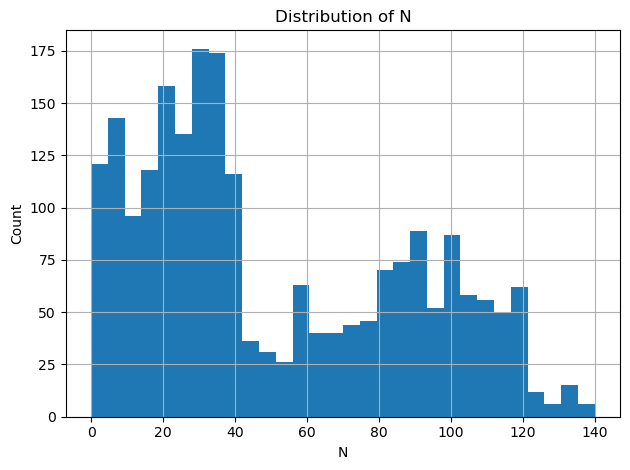

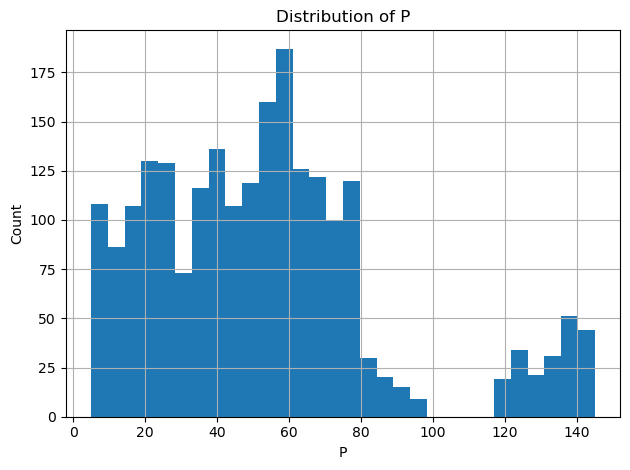

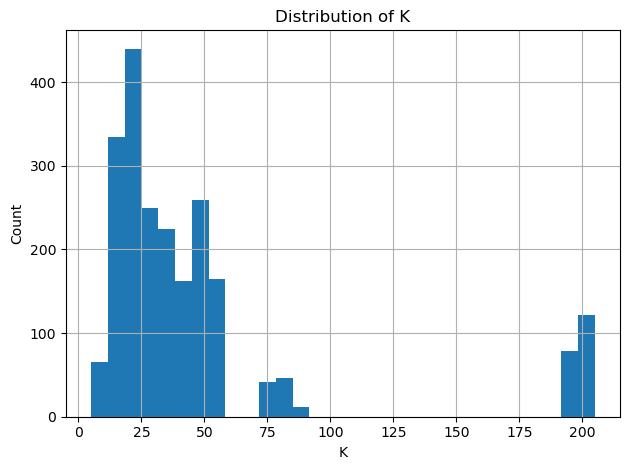

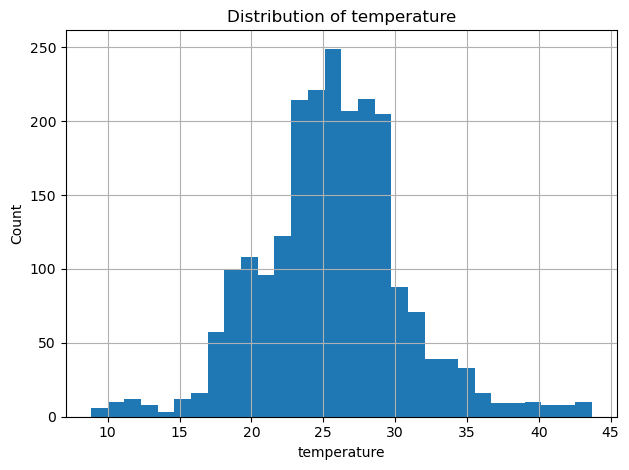

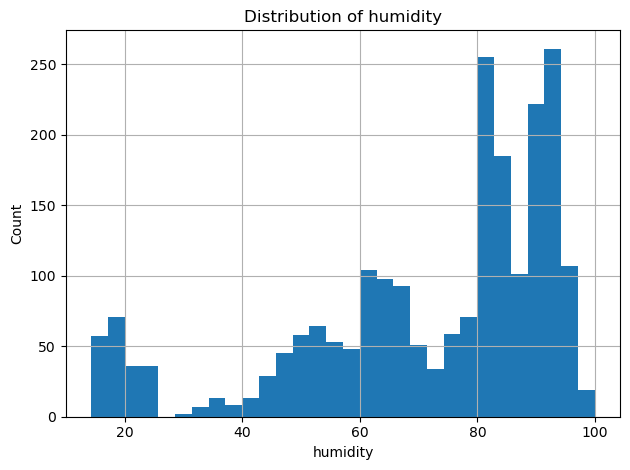

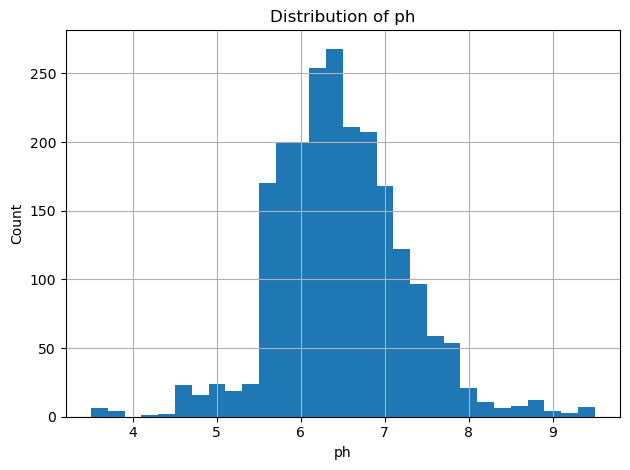

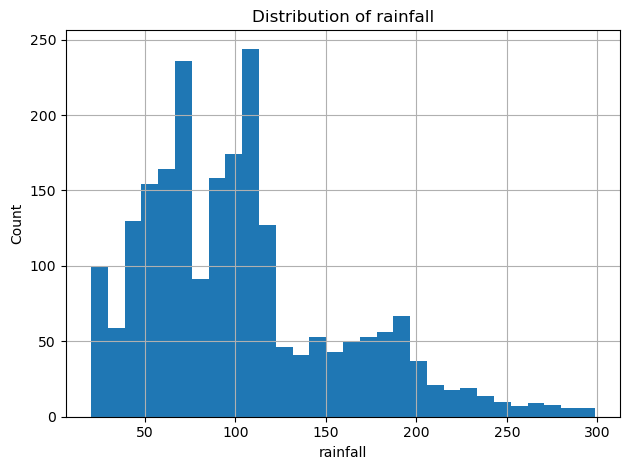

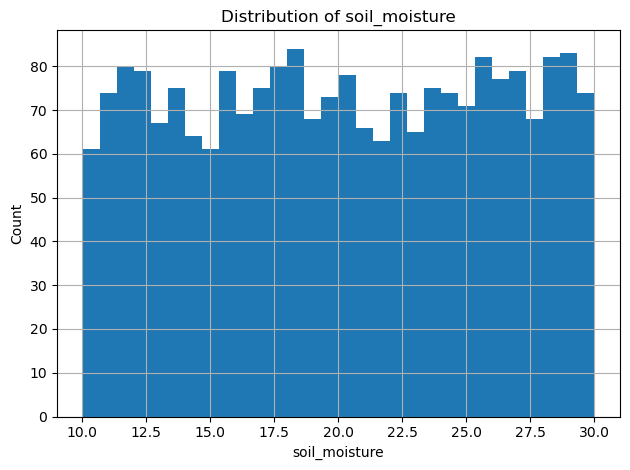

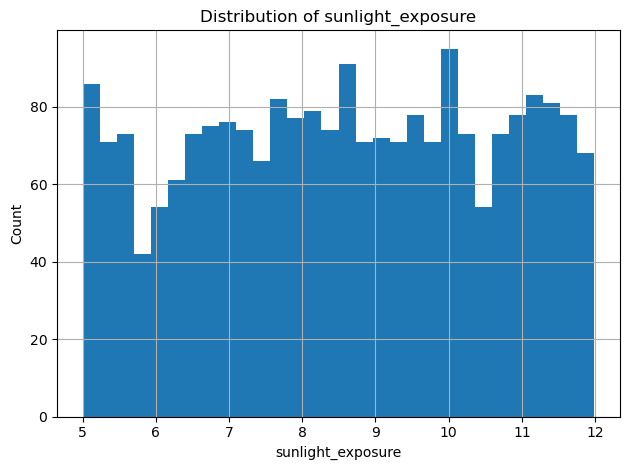

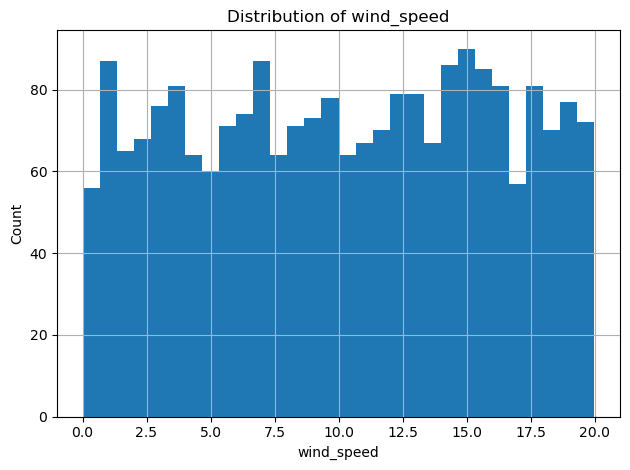

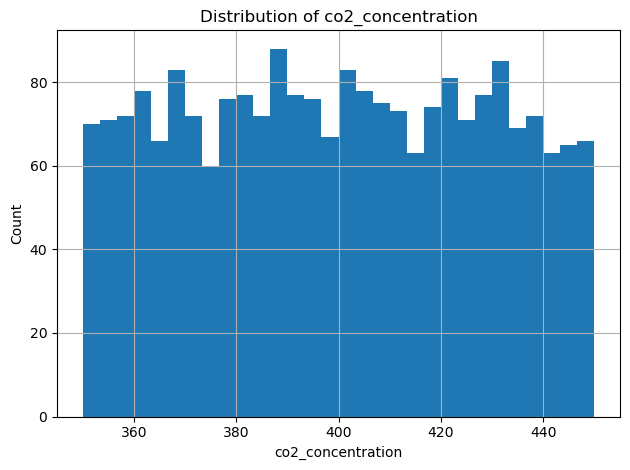

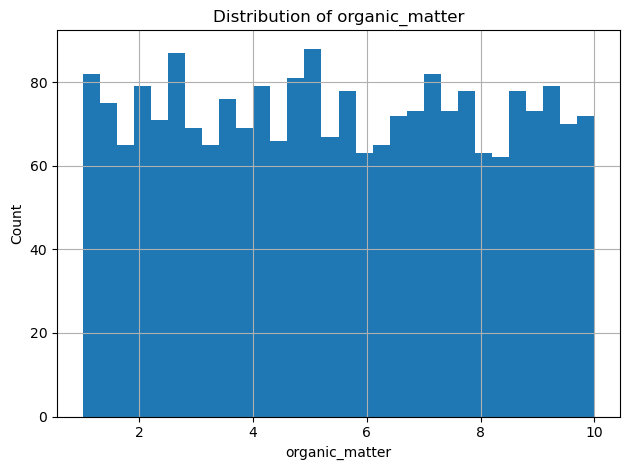

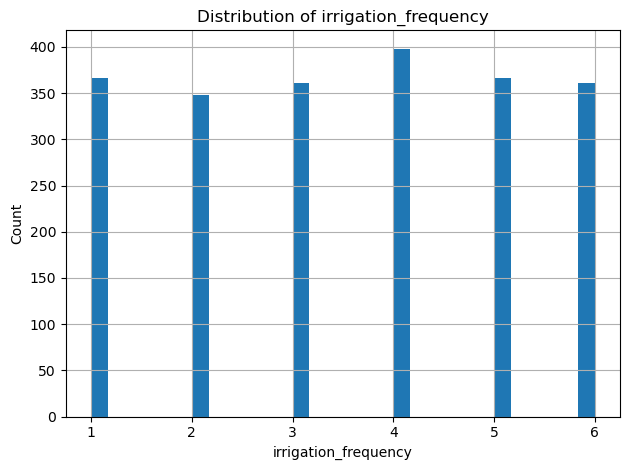

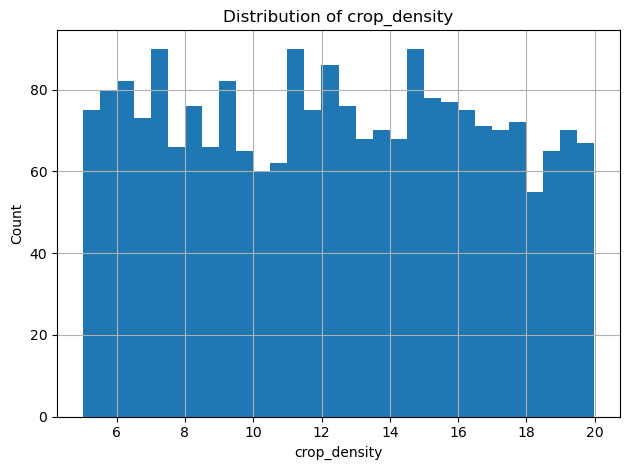

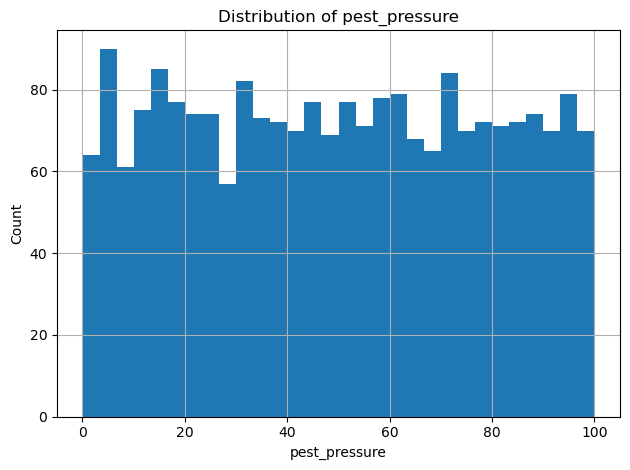

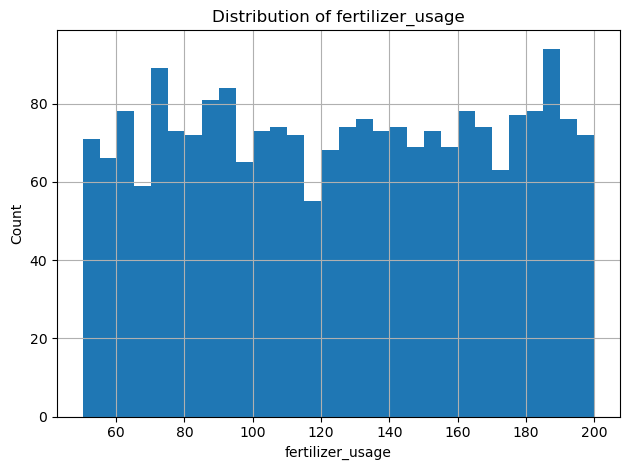

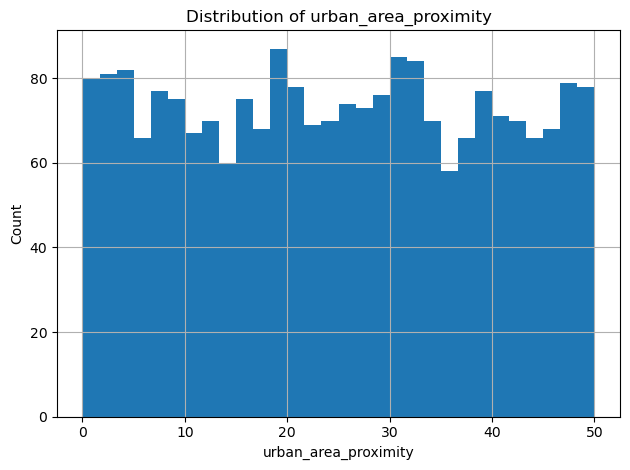

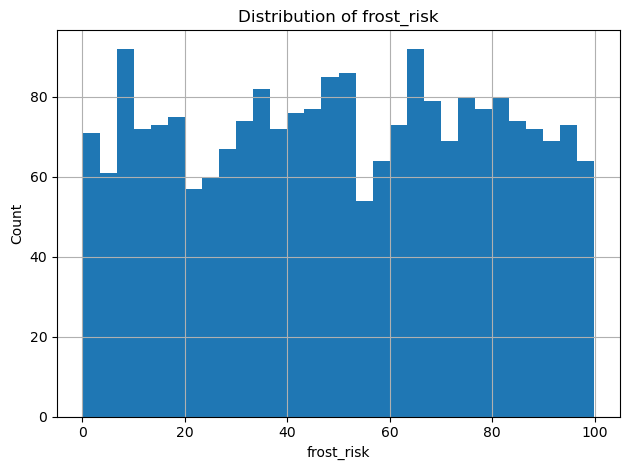

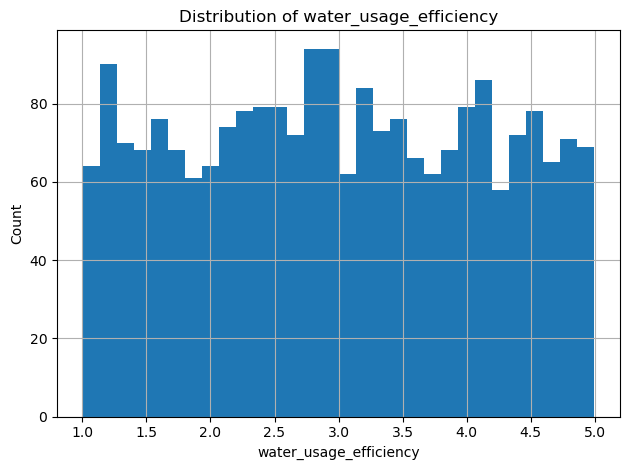

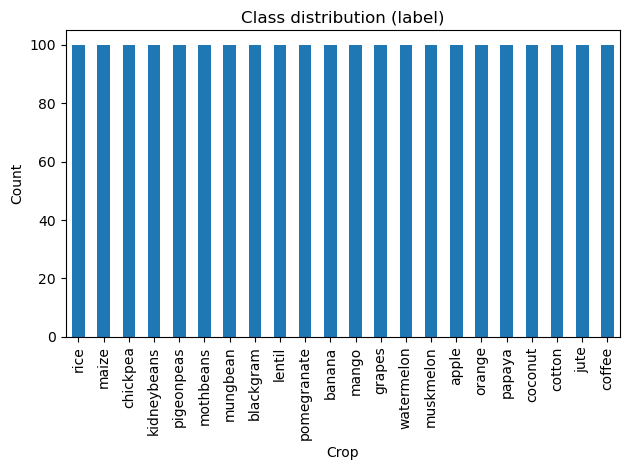

In [7]:
# Histograms for numeric columns
for c in num_cols:
    plt.figure()
    df[c].hist(bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Target balance
if 'label' in df.columns:
    plt.figure()
    df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
    plt.title("Class distribution (label)")
    plt.xlabel("Crop")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 6) EDA – outliers via IQR
# ----------------------------

In [8]:
def iqr_outlier_summary(frame, cols):
    rows = []
    for c in cols:
        q1, q3 = frame[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        outliers = ((frame[c] < lo) | (frame[c] > hi)).sum()
        rows.append((c, float(q1), float(q3), float(iqr), float(lo), float(hi), int(outliers)))
    return pd.DataFrame(rows, columns=['feature','q1','q3','iqr','lo','hi','#outliers'])

outlier_df = iqr_outlier_summary(df, num_cols)
display(outlier_df.sort_values('#outliers', ascending=False).head(10))

,feature,q1,q3,iqr,lo,hi,#outliers
2,K,20.000000,49.000000,29.000000,-23.500000,92.500000,200
1,P,28.000000,68.000000,40.000000,-32.000000,128.000000,138
6,rainfall,64.551686,124.267508,59.715822,-25.022047,213.841241,100
3,temperature,22.769375,28.561654,5.792279,14.080956,37.250073,86
5,ph,5.971693,6.923643,0.951950,4.543768,8.351567,57
4,humidity,60.261953,89.948771,29.686818,15.731726,134.478998,30
0,N,21.000000,84.250000,63.250000,-73.875000,179.125000,0
13,crop_density,8.585734,15.975567,7.389833,-2.499014,27.060316,0
17,frost_risk,26.104674,75.262676,49.158001,-47.632328,148.999677,0
16,urban_area_proximity,12.212594,37.322761,25.110168,-25.452658,74.988013,0


# ----------------------------
# 7) EDA – bivariate (vs label)
# ----------------------------

<Figure size 640x480 with 0 Axes>

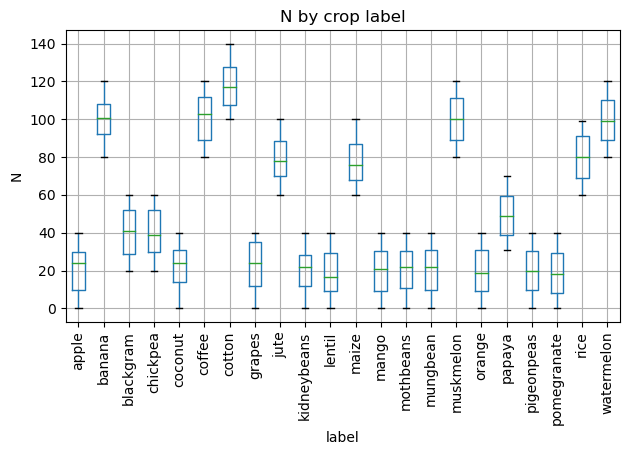

<Figure size 640x480 with 0 Axes>

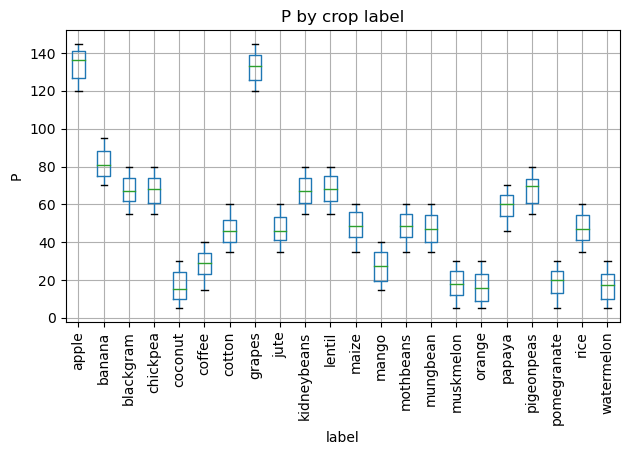

<Figure size 640x480 with 0 Axes>

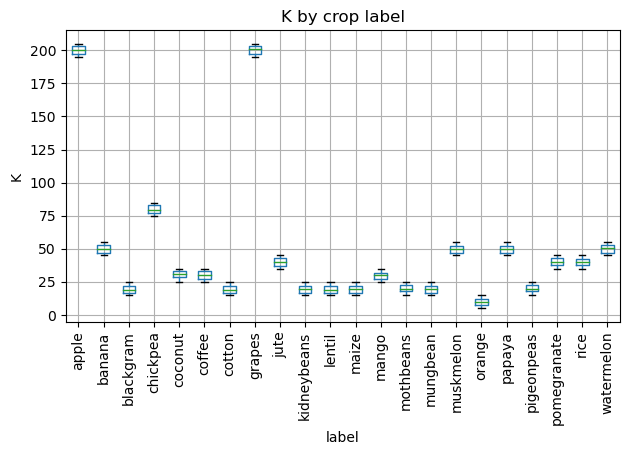

<Figure size 640x480 with 0 Axes>

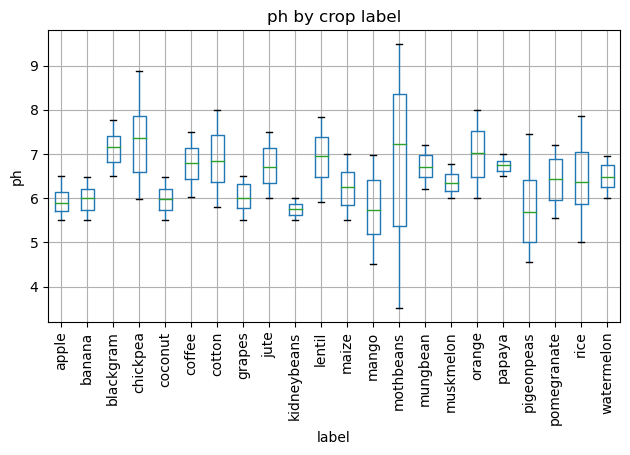

<Figure size 640x480 with 0 Axes>

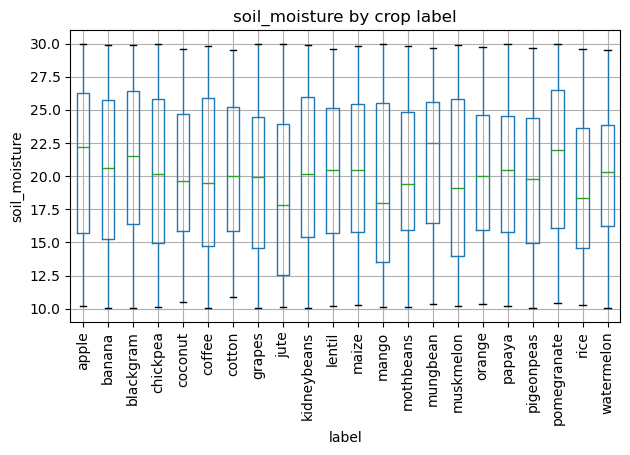

<Figure size 640x480 with 0 Axes>

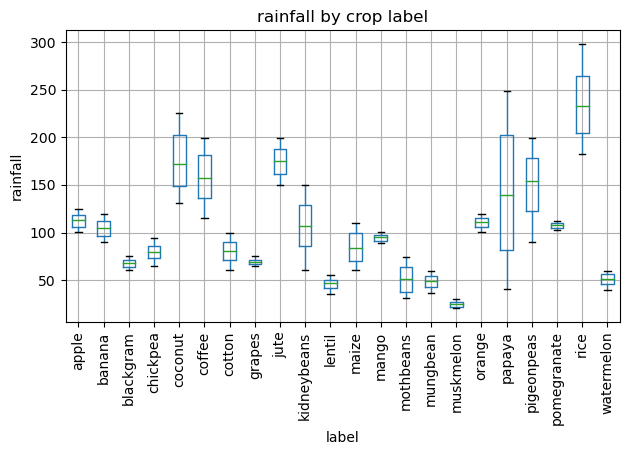

<Figure size 640x480 with 0 Axes>

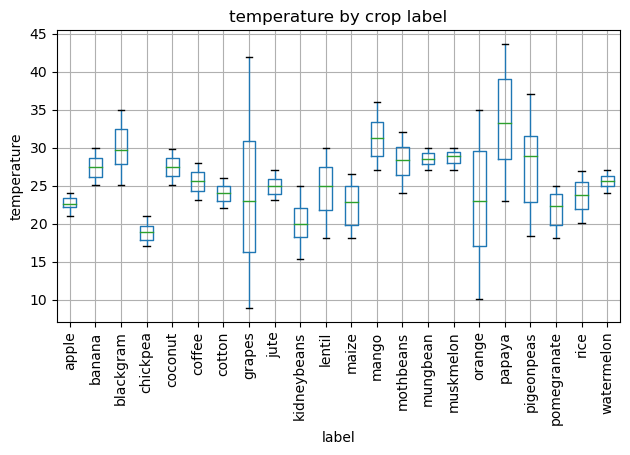

<Figure size 640x480 with 0 Axes>

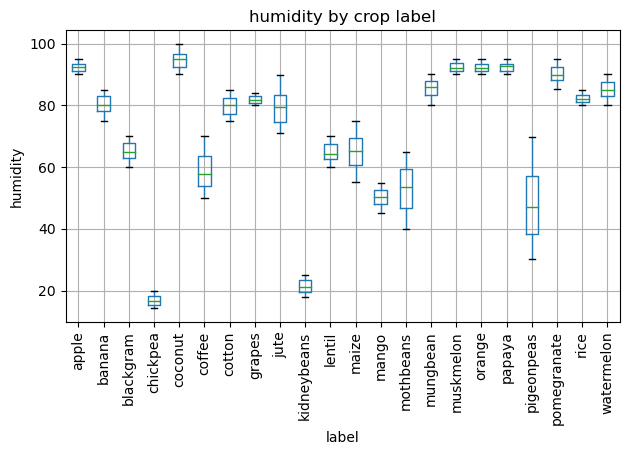

<Figure size 640x480 with 0 Axes>

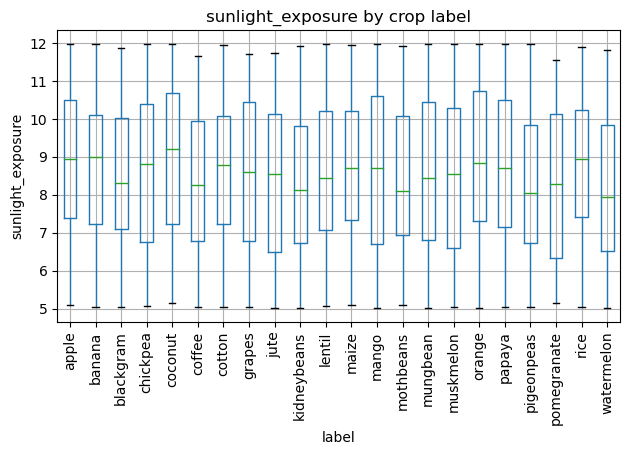

<Figure size 640x480 with 0 Axes>

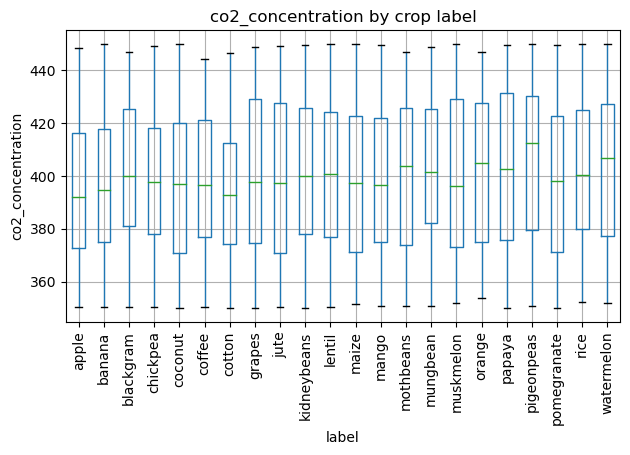

In [9]:
key_features = [c for c in ['N','P','K','ph','soil_moisture','rainfall','temperature','humidity',
                            'sunlight_exposure','co2_concentration'] if c in df.columns]

for c in key_features:
    if 'label' in df.columns:
        plt.figure()
        df.boxplot(column=c, by='label', rot=90)
        plt.title(f"{c} by crop label")
        plt.suptitle("")
        plt.xlabel("label")
        plt.ylabel(c)
        plt.tight_layout()
        plt.show()

# ----------------------------
# 8) EDA – correlation heatmap (numeric)
# ----------------------------

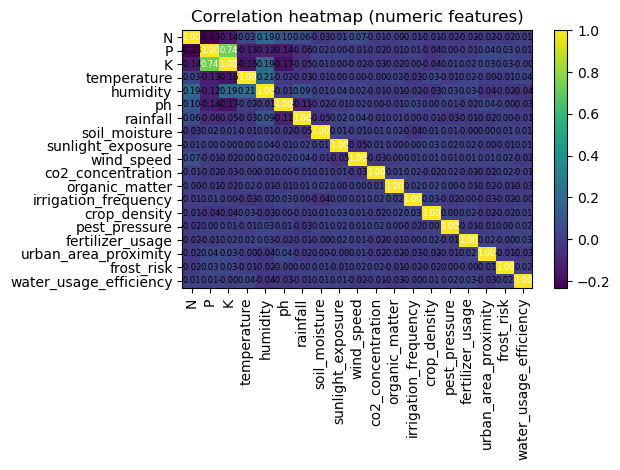

In [10]:
corr = df[num_cols].corr()

plt.figure()
plt.imshow(corr, aspect='auto')
plt.title("Correlation heatmap (numeric features)")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()

# Add scores on heatmap
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha='center', va='center', color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black',
                 fontsize=6)

plt.tight_layout()
plt.show()


# ----------------------------
# 9) EDA – scatter matrix (selected subset to keep it readable)
# ----------------------------

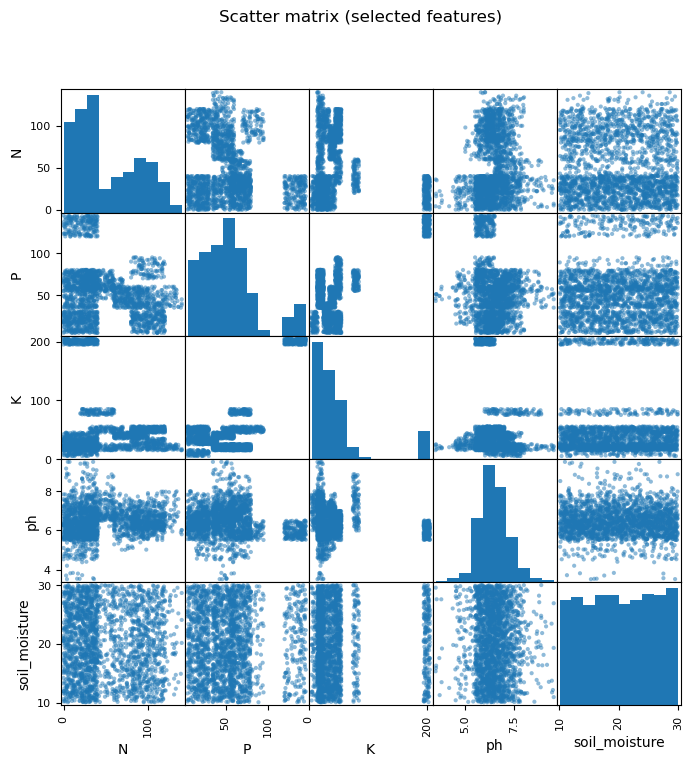

In [11]:
subset = [c for c in ['N','P','K','ph','soil_moisture','rainfall','temperature'] if c in df.columns][:5]
if len(subset) >= 2:
    axarr = scatter_matrix(df[subset], figsize=(8,8), diagonal='hist')
    plt.suptitle("Scatter matrix (selected features)")
    plt.show()

# ----------------------------
# 10) Feature Engineering – derived features
#      THI, NBR, WAI, PP, SFI (transparent heuristics)
# ----------------------------

In [12]:
df_fe = df.copy()

# THI: Temperature–Humidity Index
if {'temperature','humidity'}.issubset(df_fe.columns):
    T = df_fe['temperature']
    RH = df_fe['humidity']
    df_fe['THI'] = T - (0.55 - 0.0055*RH) * (T - 14.5)

# NBR: Nutrient Balance Ratio (higher = more balanced among N,P,K)
if {'N','P','K'}.issubset(df_fe.columns):
    npk = df_fe[['N','P','K']].astype(float)
    cv = npk.std(axis=1, ddof=0) / (npk.mean(axis=1) + 1e-9)
    df_fe['NBR'] = 1.0 / (1.0 + cv)

# WAI: Water Availability Index (soil moisture + rainfall)
if {'soil_moisture','rainfall'}.issubset(df_fe.columns):
    sm = df_fe['soil_moisture'] / 100.0
    rain_norm = (df_fe['rainfall'] / 300.0).clip(0,1)
    df_fe['WAI'] = 0.6*sm + 0.4*rain_norm

# PP: Photosynthesis Potential (sunlight × CO2 × temperature response)
def _temp_response(t, t_opt=25.0, sigma=10.0):
    return np.exp(-((t - t_opt) ** 2) / (2.0 * (sigma ** 2)))

if {'sunlight_exposure','co2_concentration','temperature'}.issubset(df_fe.columns):
    sun = (df_fe['sunlight_exposure'] / 12.0).clip(0,1)
    co2 = ((df_fe['co2_concentration'] - 350) / (1000 - 350)).clip(0,1)  # 350–1000 ppm
    temp_resp = _temp_response(df_fe['temperature'])
    df_fe['PP'] = sun * co2 * temp_resp

# SFI: Soil Fertility Index (organic matter + NPK adequacy)
if {'organic_matter','N','P','K'}.issubset(df_fe.columns):
    om = (df_fe['organic_matter'] / 10.0).clip(0,1)
    npk_mean = (df_fe[['N','P','K']].astype(float).mean(axis=1) / 140.0).clip(0,1)
    df_fe['SFI'] = (0.5*om + 0.5*npk_mean).clip(0,1)

print("Derived features added:", [c for c in ['THI','NBR','WAI','PP','SFI'] if c in df_fe.columns])

# Quick peek at derived features
disp_cols = [c for c in ['THI','NBR','WAI','PP','SFI'] if c in df_fe.columns]
if disp_cols:
    display(df_fe[disp_cols].describe().T)

Derived features added: ['THI', 'NBR', 'WAI', 'PP', 'SFI']


,count,mean,std,min,25%,50%,75%,max
THI,2200.0,23.999911,4.660058,9.359422,21.690190,24.094477,26.696962,42.569707
NBR,2200.0,0.687532,0.099519,0.461866,0.609188,0.666684,0.755237,0.986456
WAI,2200.0,0.258860,0.079564,0.091731,0.202542,0.246862,0.306073,0.565021
PP,2200.0,0.048921,0.032353,0.000002,0.021837,0.044106,0.071597,0.147267
SFI,2200.0,0.454311,0.159726,0.094953,0.330117,0.454590,0.565580,0.924817


# ----------------------------
# 11) Preprocessing setup
# ----------------------------

In [13]:
from sklearn.preprocessing import LabelEncoder

target_col = 'label'
assert target_col in df_fe.columns, "Target column 'label' is missing."

X = df_fe.drop(columns=[target_col])

# Encode y so XGBoost can handle it
le = LabelEncoder()
y = le.fit_transform(df_fe[target_col])
class_names = le.classes_

# Identify categorical codes & numeric cols again (after FE)
num_cols, cat_cols = get_columns(df_fe.drop(columns=[target_col]))

# OneHotEncoder compatibility (sklearn versions differ on param name)
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    OHE = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OHE, cat_cols)
    ],
    remainder='drop'
)

# EXTRA EDA

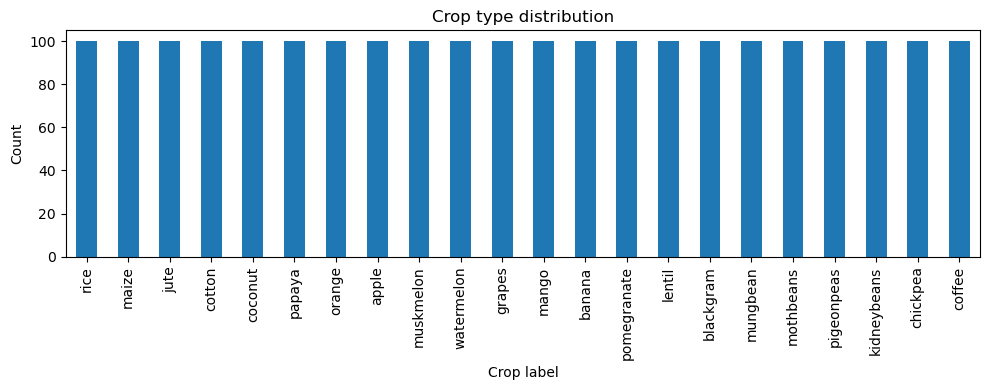

In [14]:
plt.figure(figsize=(10,4))
df['label'].value_counts().plot(kind='bar')
plt.title("Crop type distribution")
plt.xlabel("Crop label"); plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout(); plt.show()

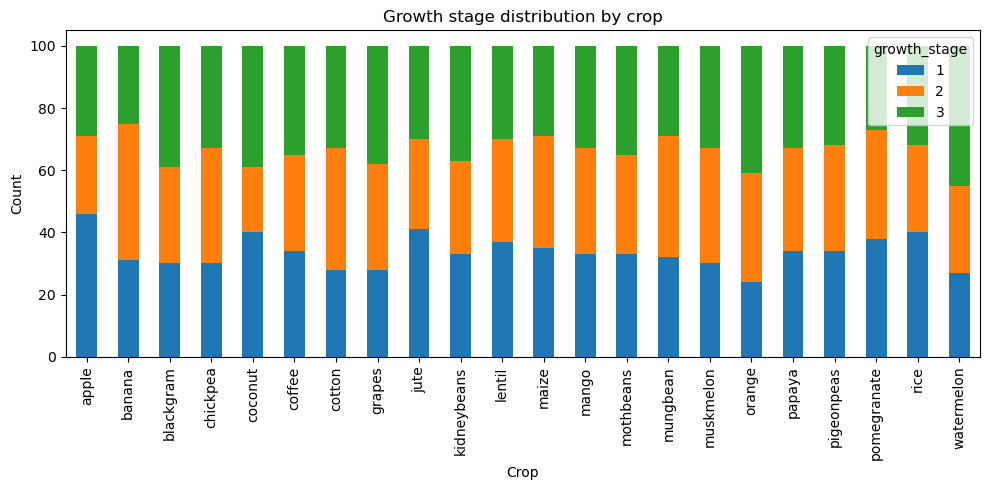

In [15]:
# H) Growth stage distribution per crop
if 'growth_stage' in df_fe.columns:
    stage_ct = pd.crosstab(df_fe['label'], df_fe['growth_stage'])
    stage_ct.plot(kind='bar', stacked=True, figsize=(10,5))
    plt.title("Growth stage distribution by crop")
    plt.xlabel("Crop"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()


# ----------------------------
# 12) Train/Validation split
# ----------------------------

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (1760, 27) (440, 27)


# ----------------------------
# 13) Principled feature selection (BEFORE final model):
#     We'll compare several selectors inside a CV GridSearch, along with models.
#     Selectors considered:
#       - Passthrough (no selection)
#       - SelectKBest (mutual_info, ANOVA F)
#       - SelectFromModel (RandomForest)
#       - RFE (LogisticRegression)
#       - PCA (retain 95% variance)  -> dimensionality reduction (not selection)
# ----------------------------

In [17]:
def make_selector_grid_stageA():
    selectors = []
    # 1) None (baseline)
    selectors.append(('none', 'passthrough', {}))
    # 2) SKB (MI)
    selectors.append((
        'skb_mi',
        SelectKBest(score_func=mutual_info_classif, k='all'),
        {'selector__k': [15, 'all']}
    ))
    # 3) SKB (ANOVA)
    selectors.append((
        'skb_anova',
        SelectKBest(score_func=f_classif, k='all'),
        {'selector__k': [15, 'all']}
    ))
    # 4) SelectFromModel with RF (embedded)
    selectors.append((
        'sfm_rf',
        SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
                        threshold='median'),
        {}
    ))
    return selectors

selectors = make_selector_grid_stageA()

# ----------------------------
# 14) Model candidates & hyperparam grids
# ----------------------------

In [18]:
models = {
    'logreg': (
        LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=None),
        {'clf__C': [0.5, 1.0, 2.0]}
    ),
    'rf': (
        RandomForestClassifier(random_state=RANDOM_STATE),
        {'clf__n_estimators': [200], 'clf__max_depth': [None, 20]}
    ),
    'xgb': (
        XGBClassifier(
            objective='multi:softprob',    
            eval_metric='mlogloss',         
            tree_method='hist',             # fast + memory friendly
            random_state=RANDOM_STATE,
            n_jobs=1,                       # keep single-threaded for stability
            verbosity=0
        ),
        {
            'clf__n_estimators': [200],     # small, solid default
            'clf__max_depth': [3, 5],       # shallow trees = light
            'clf__learning_rate': [0.05, 0.1],
            'clf__subsample': [0.8],        # mild regularization, keeps it light
            'clf__colsample_bytree': [0.8]
        }
    ),
    'svc': (
        SVC(probability=False, random_state=RANDOM_STATE), 
        {'clf__C': [0.5, 1, 2], 'clf__gamma': ['scale']}
    ),
    'knn': (
        KNeighborsClassifier(),
        {'clf__n_neighbors': [5, 11]}
    )
}

# ----------------------------
# 15) Combined pipeline + GridSearch (selectors x models)
#     Scoring: weighted F1 (robust to class imbalance), also track accuracy.
# ----------------------------

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
search_results = []
best_search = None
best_score = -np.inf
best_name = None

# ---- Progress summary (estimated total fits) ----
folds = cv.get_n_splits(X_train, y_train)
pairs = [(sel, mdl) for sel in selectors for mdl in models.items()]

def _num_configs(grid: dict) -> int:
    try:
        return len(list(ParameterGrid(grid)))
    except Exception:
        return 1  # fallback if something odd slips into the grid

total_searches = len(pairs)
total_fits_est = 0
for (sel_name, selector, sel_grid), (mdl_name, (clf, mdl_grid)) in pairs:
    merged_grid = {}
    merged_grid.update(sel_grid)
    merged_grid.update(mdl_grid)
    total_fits_est += _num_configs(merged_grid) * folds

print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting grid sweep:")
print(f"  - selectors × models: {total_searches}")
print(f"  - CV folds per config: {folds}")
print(f"  - Estimated total fits: {total_fits_est}\n")
sys.stdout.flush()

search_idx = 0
fits_done = 0

for sel_name, selector, sel_grid in selectors:
    for mdl_name, (clf, mdl_grid) in models.items():
        search_idx += 1
        name = f"{sel_name}__{mdl_name}"

        pipe = Pipeline(steps=[
            ('preprocess', preprocess),
            ('selector', selector),
            ('clf', clf)
        ])

        merged_grid = {}
        merged_grid.update(sel_grid)
        merged_grid.update(mdl_grid)

        n_configs = _num_configs(merged_grid)
        est_fits = n_configs * folds

        print(f"[{datetime.now().strftime('%H:%M:%S')}] "
              f"[{search_idx}/{total_searches}] {name} → {n_configs} configs × {folds} folds = {est_fits} fits ...",
              flush=True)

        search = GridSearchCV(
            estimator=pipe,
            param_grid=merged_grid,
            scoring={'f1w': 'f1_weighted', 'acc': 'accuracy'},
            refit='f1w',
            cv=cv,
            n_jobs=1,
            verbose=0,  # we print our own progress
            return_train_score=False,
            pre_dispatch='1*n_jobs'
        )

        t0 = time.time()
        try:
            with threadpool_limits(limits=1):
                search.fit(X_train, y_train)
        except Exception as e:
            print(f"    ✖ FAILED after {time.time()-t0:.1f}s: {e}", flush=True)
            del search
            gc.collect()
            continue

        elapsed = time.time() - t0
        fits_done += est_fits

        mean_f1 = search.best_score_
        mean_acc = search.cv_results_['mean_test_acc'][search.best_index_]
        best_params = search.best_params_
        search_results.append((name, mean_f1, mean_acc, best_params))

        if mean_f1 > best_score:
            best_score = mean_f1
            best_search = search
            best_name = name

        print(f"    ✓ Done in {elapsed:.1f}s | best F1w={mean_f1:.4f} | acc={mean_acc:.4f} "
              f"| progress ≈ {fits_done}/{total_fits_est} fits", flush=True)

        del search
        gc.collect()

results_df = pd.DataFrame(search_results, columns=['candidate','cv_f1_weighted','cv_accuracy','best_params'])
display(results_df.sort_values('cv_f1_weighted', ascending=False).head(10))

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] BEST (CV): {best_name}  |  CV F1_weighted = {best_score:.4f}")
print("Best params:", best_search.best_params_)
best_model = best_search.best_estimator_

[15:03:34] Starting grid sweep:
  - selectors × models: 20
  - CV folds per config: 5
  - Estimated total fits: 420

[15:03:34] [1/20] none__logreg → 3 configs × 5 folds = 15 fits ...
    ✓ Done in 0.8s | best F1w=0.9497 | acc=0.9500 | progress ≈ 15/420 fits
[15:03:35] [2/20] none__rf → 2 configs × 5 folds = 10 fits ...
    ✓ Done in 8.7s | best F1w=0.9903 | acc=0.9903 | progress ≈ 25/420 fits
[15:03:44] [3/20] none__xgb → 4 configs × 5 folds = 20 fits ...
    ✓ Done in 22.6s | best F1w=0.9897 | acc=0.9898 | progress ≈ 45/420 fits
[15:04:07] [4/20] none__svc → 3 configs × 5 folds = 15 fits ...
    ✓ Done in 2.9s | best F1w=0.9360 | acc=0.9364 | progress ≈ 60/420 fits
[15:04:10] [5/20] none__knn → 2 configs × 5 folds = 10 fits ...
    ✓ Done in 0.1s | best F1w=0.6952 | acc=0.7017 | progress ≈ 70/420 fits
[15:04:10] [6/20] skb_mi__logreg → 6 configs × 5 folds = 30 fits ...
    ✓ Done in 14.5s | best F1w=0.9651 | acc=0.9653 | progress ≈ 100/420 fits
[15:04:24] [7/20] skb_mi__rf → 4 config

,candidate,cv_f1_weighted,cv_accuracy,best_params
6,skb_mi__rf,0.991970,0.992045,"{'clf__max_depth': None, 'clf__n_estimators': ..."
11,skb_anova__rf,0.991430,0.991477,"{'clf__max_depth': None, 'clf__n_estimators': ..."
16,sfm_rf__rf,0.991401,0.991477,"{'clf__max_depth': None, 'clf__n_estimators': ..."
7,skb_mi__xgb,0.990863,0.990909,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
17,sfm_rf__xgb,0.990847,0.990909,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
1,none__rf,0.990264,0.990341,"{'clf__max_depth': None, 'clf__n_estimators': ..."
12,skb_anova__xgb,0.989734,0.989773,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
2,none__xgb,0.989710,0.989773,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
13,skb_anova__svc,0.966846,0.967045,"{'clf__C': 2, 'clf__gamma': 'scale', 'selector..."
8,skb_mi__svc,0.966640,0.967045,"{'clf__C': 2, 'clf__gamma': 'scale', 'selector..."



[15:08:29] BEST (CV): skb_mi__rf  |  CV F1_weighted = 0.9920
Best params: {'clf__max_depth': None, 'clf__n_estimators': 200, 'selector__k': 15}


# ----------------------------
# 16) What feature set did the selector choose?
#     (If applicable: SKB/SFM/RFE; PCA gives components, not feature subset)
# ----------------------------

In [20]:
def resolved_feature_names(fitted_preprocess, num_cols, cat_cols):
    # after fit: numeric names are num_cols; categorical names are OHE expanded
    names = []
    for name, trans, cols in fitted_preprocess.transformers_:
        if name == 'num':
            names.extend(list(cols))
        elif name == 'cat':
            ohe = trans
            try:
                names.extend(ohe.get_feature_names_out(cols))
            except Exception:
                # fallback, generic names
                for c in cols:
                    categories = getattr(ohe, 'categories_', [[]])[0]
                names.extend([f"{c}_cat_{i}" for c in cols for i in range(10)])
    return names

pre_fitted = best_model.named_steps['preprocess']
feat_names = resolved_feature_names(pre_fitted, num_cols, cat_cols)

selector_step = best_model.named_steps['selector']
selected_feature_names = None

if hasattr(selector_step, 'get_support'):
    mask = selector_step.get_support()
    if mask is not None and hasattr(mask, '__len__') and len(mask) == len(feat_names):
        selected_feature_names = [f for f, m in zip(feat_names, mask) if m]
        print(f"\nSelected features ({len(selected_feature_names)}):")
        for f in selected_feature_names[:40]:
            print("  -", f)
        if len(selected_feature_names) > 40:
            print(f"  ... and {len(selected_feature_names)-40} more")
elif isinstance(selector_step, PCA):
    print("\nSelector is PCA: dimensionality reduced to", selector_step.n_components_, "components (no direct feature names).")
else:
    print("\nNo feature selection applied (passthrough).")


Selected features (15):
  - N
  - P
  - K
  - temperature
  - humidity
  - ph
  - rainfall
  - THI
  - NBR
  - WAI
  - SFI
  - water_source_type_2
  - water_source_type_3
  - growth_stage_1
  - growth_stage_2


# ----------------------------
# 17) Final evaluation on HOLDOUT set
# ----------------------------


=== HOLDOUT PERFORMANCE ===
Accuracy:        0.9932
F1 (weighted):   0.9932

Classification report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.90      0.95        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.91      1.00      0.95        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00

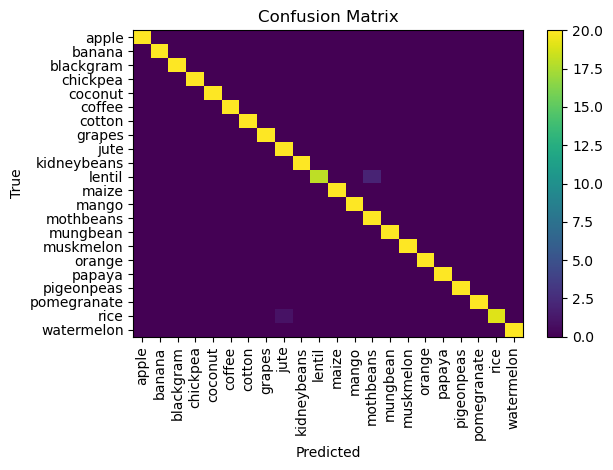

In [21]:
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1w = f1_score(y_test, y_pred, average='weighted')
print("\n=== HOLDOUT PERFORMANCE ===")
print(f"Accuracy:        {acc:.4f}")
print(f"F1 (weighted):   {f1w:.4f}\n")
print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix (use encoded label indices + readable tick labels)
labels_sorted = list(range(len(class_names)))  # 0..K-1 in encoder order
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.title('Confusion Matrix')
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()

# ----------------------------
# 18) Learning curve for best pipeline (data sufficiency insight)
# ----------------------------

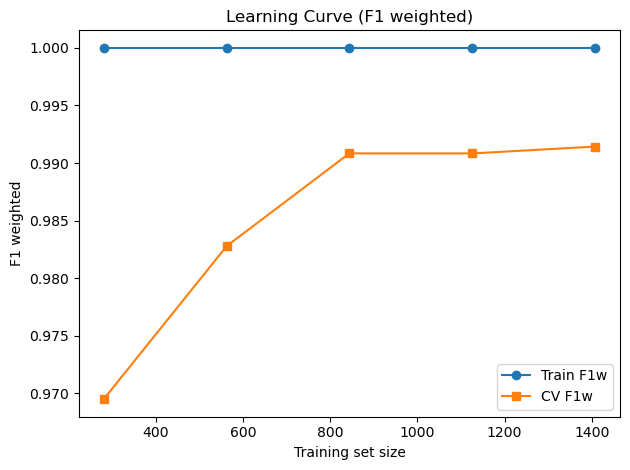

In [22]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train, y=y_train,
    cv=cv, scoring='f1_weighted',
    train_sizes=np.linspace(0.2, 1.0, 5),
    n_jobs=-1, shuffle=True, random_state=RANDOM_STATE
)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train F1w')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='s', label='CV F1w')
plt.title('Learning Curve (F1 weighted)')
plt.xlabel('Training set size')
plt.ylabel('F1 weighted')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 19) Permutation importance (top-k)
# ----------------------------

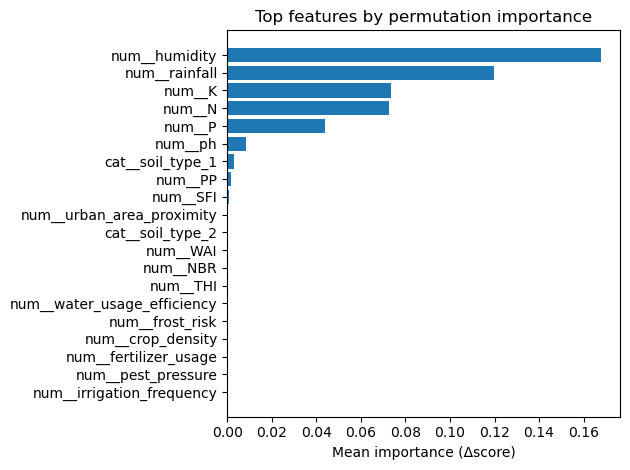

,feature,importance_mean
4,num__humidity,0.167942
6,num__rainfall,0.119749
2,num__K,0.073530
0,num__N,0.072631
1,num__P,0.043846
5,num__ph,0.008590
24,cat__soil_type_1,0.002868
22,num__PP,0.001438
23,num__SFI,0.000955
16,num__urban_area_proximity,0.000000


In [23]:
# Use a manageable sample for speed
rng = np.random.RandomState(RANDOM_STATE)
idx = rng.choice(len(X_test), size=min(300, len(X_test)), replace=False)

def _safe_sample(X, y, idx):
    # X: DataFrame or ndarray; y: Series or ndarray
    # Prefer keeping/rehydrating a DataFrame so ColumnTransformer has column names.
    if hasattr(X, "iloc"):         # DataFrame
        X_s = X.iloc[idx]
    else:                          # ndarray
        # Try to rebuild a DataFrame using training columns if available
        cols = getattr(X_train, "columns", None)
        X_s = pd.DataFrame(X[idx], columns=cols) if cols is not None else X[idx]

    y_s = y.iloc[idx] if hasattr(y, "iloc") else y[idx]
    return X_s, y_s

X_sample, Y_sample = _safe_sample(X_test, y_test, idx)


with threadpool_limits(limits=1):
    r = permutation_importance(
        best_model, X_sample, Y_sample,
        n_repeats=7,
        random_state=RANDOM_STATE,
        scoring='f1_weighted'
    )
    
# Get feature names from the fitted preprocess step
pre = best_model.named_steps['preprocess']

try:
    # sklearn >=1.0 typically supports this
    feat_names = list(pre.get_feature_names_out())
except Exception:
    # Fallback: try to build something reasonable
    # Assume we still have num_cols and cat_cols in scope; otherwise replace with lists or pull from earlier cell.
    num_cols_safe = [c for c in num_cols] if 'num_cols' in globals() else []
    cat_cols_safe = [c for c in cat_cols] if 'cat_cols' in globals() else []
    # Generic names (won’t expand OHE categories, but keeps lengths/labels consistent downstream)
    feat_names = [f"num__{c}" for c in num_cols_safe] + [f"cat__{c}" for c in cat_cols_safe]


# Build feature names that MATCH r.importances_mean length
n_imp = len(r.importances_mean)
selector_step = best_model.named_steps['selector']

def _final_feature_names():
    # If PCA: synthesize PC names
    if isinstance(selector_step, PCA):
        return [f"PC{i+1}" for i in range(n_imp)]

    # If selector has mask, try to map mask -> names
    if hasattr(selector_step, "get_support"):
        try:
            mask = selector_step.get_support()
            if (mask is not None and hasattr(mask, "__len__")
                    and len(mask) == len(feat_names)):
                names = [f for f, m in zip(feat_names, mask) if m]
                if len(names) == n_imp:
                    return names
        except Exception:
            pass

    # 'passthrough' or anything else
    if n_imp == len(feat_names):
        return feat_names

    # Last-resort: length mismatch; truncate or synthesize
    return (feat_names[:n_imp] if n_imp < len(feat_names)
            else [f"feat_{i}" for i in range(n_imp)])

final_names = _final_feature_names()

importances = pd.DataFrame({
    'feature': final_names,
    'importance_mean': r.importances_mean
}).sort_values('importance_mean', ascending=False)

topk = min(20, importances.shape[0])
plt.figure()
plt.barh(importances['feature'][:topk][::-1], importances['importance_mean'][:topk][::-1])
plt.title('Top features by permutation importance')
plt.xlabel('Mean importance (Δscore)')
plt.tight_layout(); plt.show(); plt.close()

display(importances.head(topk))

# ----------------------------
# 20) Inference demo
# ----------------------------

In [24]:
sample = X_test.iloc[[0]]
pred = best_model.predict(sample)[0]
print("\nSample prediction:", le.inverse_transform([pred])[0])

# show top class probabilities if supported
try:
    proba = best_model.predict_proba(sample)[0]
    class_indices = best_model.named_steps['clf'].classes_  # encoded ints
    order = np.argsort(-proba)[:5]
    print("Top probabilities:")
    for i in order:
        # Map encoded class index -> original name
        print(f"  {le.inverse_transform([class_indices[i]])[0]}: {proba[i]:.3f}")
except Exception:
    pass




Sample prediction: orange
Top probabilities:
  orange: 0.910
  pomegranate: 0.070
  blackgram: 0.005
  coconut: 0.005
  cotton: 0.005


In [25]:
# === EXPORT ARTIFACTS FOR THE APP ===
import json, joblib
from pathlib import Path

ART_DIR = Path("webapp_artifacts")
ART_DIR.mkdir(exist_ok=True)

# 1) Save the best model (a Pipeline) and the label encoder
joblib.dump(best_model, ART_DIR/"best_model.joblib")
joblib.dump(le,         ART_DIR/"label_encoder.joblib")

# 2) Build a simple schema for inputs (dtype + sensible default + choices for categoricals)
schema = {}
X_train_full = X  # original feature frame before split (from your notebook)
for c in X_train_full.columns:
    series = X_train_full[c]
    if str(series.dtype) in ("object", "category", "bool"):
        # categorical-like
        choices = sorted([str(v) for v in series.dropna().unique().tolist()][:50])  # cap for UI
        default = str(series.mode(dropna=True).iloc[0]) if not series.mode(dropna=True).empty else (choices[0] if choices else "")
        schema[c] = {"type":"categorical", "default":default, "choices":choices}
    else:
        # numeric-like
        default = float(series.median()) if series.notna().any() else 0.0
        lo = float(series.quantile(0.05)) if series.notna().any() else 0.0
        hi = float(series.quantile(0.95)) if series.notna().any() else 1.0
        schema[c] = {"type":"numeric", "default":default, "range":[lo, hi]}

with open(ART_DIR/"schema.json", "w", encoding="utf-8") as f:
    json.dump(schema, f, indent=2)

print("Saved to:", ART_DIR.resolve())


Saved to: /u2/users/rwa274/Crop/webapp_artifacts
